In [239]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [240]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [241]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text, desc

In [242]:
def print_tables():
    # Display the tables and their columns
    inspector = inspect(engine)
    tables = inspector.get_table_names()

    for table in tables:
        print(f'For table: {table}')
        columns = inspector.get_columns(table)
        for column in columns:
            print(column['name'], column['type'])
        print()

In [243]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [244]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [245]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [246]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [247]:
# Create our session (link) from Python to the DB
session = Session(engine)
print_tables()

For table: measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

For table: station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



# Exploratory Precipitation Analysis

In [248]:
# Read the query
measurement = session.query(Measurement)

# Find the most recent date in the data set.
recent = measurement.order_by(Measurement.date.desc()).first()
print(f'Most recent date in dataset: {recent.date}')


Most recent date in dataset: 2017-08-23


The last 12 months of data are 2016-08-23 through 2017-08-23


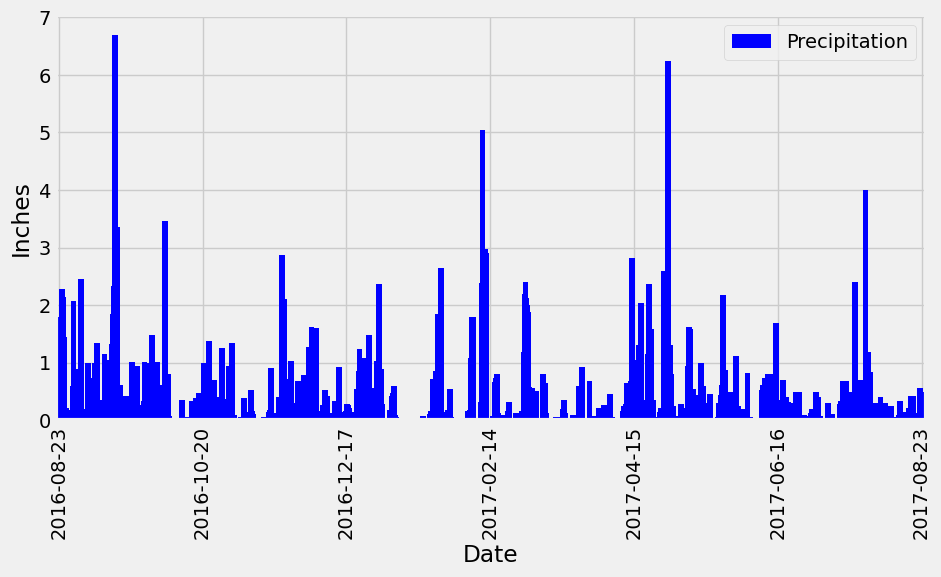

In [251]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = pd.to_datetime(recent.date)

# Calculate the date one year from the last date in data set.
prev_year = recent_date - relativedelta(years=1)

recent_date = recent_date.strftime('%Y-%m-%d')
prev_year = prev_year.strftime('%Y-%m-%d')
print(f'The last 12 months of data are {prev_year} through {recent_date}')

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, 
                        Measurement.station, 
                        Measurement.prcp).\
    filter(Measurement.date >= prev_year,
           Measurement.date <= recent_date).\
        order_by(Measurement.date).all()
        
       
# # Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results)

# Rename 'prcp' to 'Percipitation'        
df.rename(columns={'prcp': 'Precipitation'}, inplace=True) 
# print(df)

# Sort the dataframe by date
# All ready done with the 'order_by()'

# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot(
        x='date', 
        y='Precipitation', 
        kind='bar', 
        width=15,
        figsize=(10, 5), 
        color='blue', 
        legend=True)
# plt.title('Precipitation in Last 12 Months of Data')
plt.xlabel('Date')
plt.ylabel('Inches')

# Set the x-ticks to show only 6 evenly spaced ticks
num_ticks = 6
ax.set_xticks(range(0, len(df), max(1, len(df) // num_ticks)))
ax.set_xticklabels(df['date'][::max(1, len(df) // num_ticks)], rotation=90)
plt.show()

In [ ]:
# Use Pandas to calculate the summary statistics for the precipitation data
df['Precipitation'].describe()

# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number of stations in the dataset
station = session.query(Station)
print(f'There are {station.count()} stations in the dataset')

In [ ]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(
    Measurement.station,
    func.count(Measurement.station).label('count')).\
        group_by(Measurement.station).order_by(desc('count')).all()
        
station_counts_df = pd.DataFrame(station_counts, columns=['station_id', 'count'])

print(station_counts_df)

In [ ]:
# Isolate the name of the most active station
most_active_station = station_counts_df['station_id'][0]
print(f'The most active station is {most_active_station}')

In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_results = session.query(
    func.min(Measurement.tobs).label('lowest'),
    func.max(Measurement.tobs).label('highest'),
    func.avg(Measurement.tobs).label('average')).filter(Measurement.station == most_active_station).all()

print(f'Station {most_active_station}:')
print(f'lowest temperature: {lowest}F')
print(f'highest temperature: {highest}F')
print(f'average temperature: {average:.1f}F')

The last 12 months of data are 2016-08-23 through 2017-08-23 for USC00519281


<Axes: xlabel='Temperature', ylabel='Frequency'>

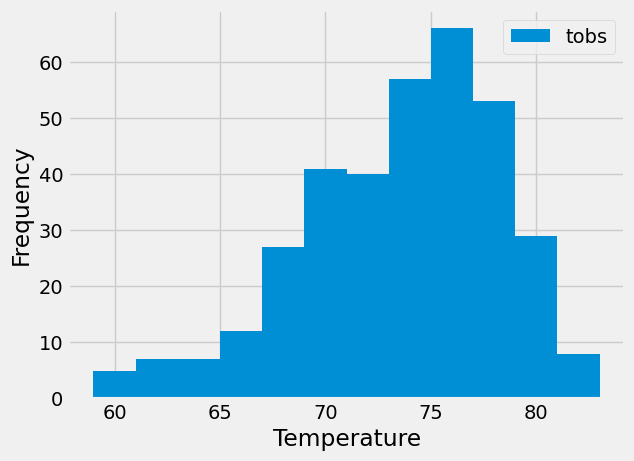

In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_recent_date = df['date'].max()
recent_date = pd.to_datetime(most_recent_date)

prev_year = recent_date - relativedelta(years=1)

recent_date = recent_date.strftime('%Y-%m-%d')
prev_year = prev_year.strftime('%Y-%m-%d')

print(f'The last 12 months of data are {prev_year} through {recent_date} for {most_active_station}')

results = session.query(Measurement.date, 
                        Measurement.station, 
                        Measurement.tobs).\
    filter(Measurement.date >= prev_year,
           Measurement.date <= recent_date,
           Measurement.station == most_active_station).\
        order_by(Measurement.date).all()

df = pd.DataFrame(results)

df.plot(x='date', 
        y='tobs', 
        kind='hist', 
        bins=12, 
        xlabel='Temperature', 
        ylabel='Frequency')
                     


# Close Session

In [ ]:
# Close Session
session.close()